In [1]:
import pandas as pd
import os
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from copy import deepcopy

def scale_min_max(ser, minimum=-1, maximum=1):
    ser_min = ser.min()
    ser_max = ser.max()
    return minimum + ((maximum-minimum)*(ser-ser_min))/(ser_max-ser_min)

def compute_fft_aggregate(sig):
    scaled = scale_min_max(sig)
    ac_component = scaled - scaled.mean()
    return np.fft.fft(ac_component)

def decompose(df, freq=96):
    res = sm.tsa.seasonal_decompose(df.fillna(method='ffill').values, freq=freq)
    return pd.DataFrame({"seasonal":res.seasonal, "trend":res.trend, "obs":res.observed}, index=df.index)


In [2]:
st = pd.HDFStore(os.path.expanduser("/Users/nipunbatra/wiki-all.h5"))

In [3]:
metadata_df = pd.read_csv("/Users/nipunbatra/w/dataport-metadata.csv",index_col=0)

In [4]:
austin_data = metadata_df[metadata_df['city'] == "Austin"]

In [5]:
austin_homes = austin_data.index.values.astype('int')

In [6]:
months=12
start='1-1-2014'
start_month=1
end = '12-31-2014'
end_month=13

In [9]:
#to_ignore = [5400, 6800, 7208,8555,9142, 9958]
to_ignore = []

In [10]:
out = {}
for home in austin_homes[:]:
    if home in to_ignore:
        continue
    try:
        data_df = st['/%d' %home][start:end]
        data_df_resampled = data_df.resample("1M", how="sum")
        df_res_kwh = data_df_resampled.div(1000)
        fridge = np.array([np.NaN]*months)
        hvac = np.array([np.NaN]*months)
        dw = np.array([np.NaN]*months)
        dr = np.array([np.NaN]*months)
        wm = np.array([np.NaN]*months)
        aggregate = np.array([np.NaN]*months)

        if "refrigerator1" in df_res_kwh.columns:
            fridge = df_res_kwh['refrigerator1'].squeeze().values
        if 'air1' in df_res_kwh.columns:
            hvac = df_res_kwh['air1'].squeeze().values
        if 'dishwasher1' in df_res_kwh.columns:
            dw = df_res_kwh['dishwasher1'].squeeze().values
        if 'clotheswasher1' in df_res_kwh.columns:
            wm = df_res_kwh['clotheswasher1'].squeeze().values
        if 'drye1' in df_res_kwh.columns:
            dr = df_res_kwh['drye1'].squeeze().values
        
    
        aggregate = df_res_kwh["use"].values

        out[home] = np.hstack([aggregate, hvac, fridge,dw,dr, wm])
    except:
        pass
    

In [14]:
a = pd.Series({x:len(out[x]) for x in out.keys()})

In [18]:
a = a[a==72]

In [20]:
a.index

Int64Index([  22,   26,   59,   68,   86,   93,   94,  114,  115,  135,
            ...
            9922, 9926, 9929, 9931, 9933, 9934, 9938, 9939, 9942, 9982],
           dtype='int64', length=360)

In [21]:
out = {x:out[x] for x in a.index}

In [29]:
df = pd.DataFrame(out).T
df.columns=np.hstack([['aggregate_%d' %month for month in range(start_month,end_month)],
                          ['hvac_%d' %month for month in range(start_month,end_month)],
                          ['fridge_%d' %month for month in range(start_month,end_month)],
                          ['dw_%d' %month for month in range(start_month,end_month)],
                          ['dr_%d' %month for month in range(start_month,end_month)],
                          ['wm_%d' %month for month in range(start_month,end_month)]
                          ])

In [30]:
df.describe()

,aggregate_1,aggregate_2,aggregate_3,aggregate_4,aggregate_5,aggregate_6,aggregate_7,aggregate_8,aggregate_9,aggregate_10,...,wm_3,wm_4,wm_5,wm_6,wm_7,wm_8,wm_9,wm_10,wm_11,wm_12
count,340.000000,342.000000,346.000000,349.000000,351.000000,351.000000,351.000000,351.000000,352.000000,352.000000,...,145.000000,147.000000,148.000000,152.000000,154.000000,155.000000,152.000000,152.000000,152.000000,154.000000
mean,670.749272,606.701074,599.606025,646.718663,807.819070,1101.937507,1247.967270,1395.295277,1062.557876,851.961226,...,7.003714,5.338371,4.107841,4.497386,4.304612,4.379797,4.221651,4.025831,4.985008,5.118707
std,522.466651,461.755202,421.925339,483.462303,642.263389,745.093741,838.994480,936.290469,725.574771,594.600434,...,23.316188,15.768379,3.090764,4.570781,3.981354,4.105034,3.549894,3.223311,7.979552,9.984302
min,1.867500,10.789917,41.979450,77.954910,92.283058,153.584259,5.680950,80.255836,28.403950,130.017227,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,382.789604,363.809837,352.101738,342.955414,414.493637,627.916809,709.020294,780.519165,611.794479,477.057907,...,2.448700,2.088892,2.114763,2.113496,1.941342,2.172283,1.982467,2.105075,2.104817,2.422483
50%,542.694489,492.147476,514.340942,555.554016,699.630920,999.114502,1139.219604,1323.019043,967.018646,742.531342,...,3.660133,3.471667,3.149225,3.430133,3.146583,3.274633,3.281317,3.158833,3.423367,3.490767
75%,803.992844,741.986725,758.714310,824.528625,983.457977,1386.667969,1601.920898,1790.513611,1328.565674,1073.670685,...,5.765250,5.458333,5.320487,5.568275,5.610788,5.439667,5.265358,5.011533,5.742812,5.572896
max,6072.448242,5176.299805,5001.274902,5993.735352,7633.365723,8348.136719,9386.385742,11638.348633,8329.752930,6694.594727,...,242.600021,191.390106,18.536350,41.690884,31.294167,38.554035,27.695732,20.446417,93.735222,121.576500


In [31]:
austin_md = pd.read_csv("../data/input/austin_md.csv",index_col=0)

In [33]:
austin_md.head()

,house_num_rooms,area,num_occupants
26,6,2047,4
59,11,3600,7
94,3,1713,2
101,5,1300,3
121,10,1900,3


In [35]:
df['area'] = austin_md['area']

In [37]:
df['num_rooms'] = austin_md['house_num_rooms']
df['num_occupants'] = austin_md['num_occupants']

In [40]:
md_not_null = df['area'].dropna().index
df = df.ix[md_not_null]

In [41]:
aggregate_no_null = df[['aggregate_%d' %month for month in range(start_month, end_month)]].dropna().index

In [44]:
df = df.ix[aggregate_no_null]

In [47]:
len(df[['hvac_%d' %month for month in range(start_month, end_month)]].dropna().index)

75

In [48]:
df.to_csv("../data/input/unscaled_austin_df.csv")

In [49]:
def scale_0_1(ser, minimum=None, maximum=None):
    if minimum is not None:
        pass
    else:
        minimum = ser.min()
        maximum = ser.max()
    return (ser-minimum).div(maximum-minimum)

    #Normalising features
max_aggregate = df[["aggregate_%d" % i for i in range(start_month, end_month)]].max().max()
min_aggregate = df[["aggregate_%d" % i for i in range(start_month, end_month)]].min().min()
df[["aggregate_%d" % i for i in range(start_month, end_month)]] = scale_0_1(df[["aggregate_%d" % i for i in range(start_month, end_month)]],
                                                                min_aggregate, max_aggregate)

df["area"] = scale_0_1(df["area"])
df["num_rooms"] = scale_0_1(df["num_rooms"])
df["num_occupants"] = scale_0_1(df["num_occupants"])



#df = df[df.index!=2931]
#df = df[df.index!=516]

In [50]:
df.to_csv("../data/input/austin_df.csv")

In [51]:
all_homes = {}

all_homes['hvac'] = df[['hvac_%d' %month for month in range(start_month, end_month)]].dropna().index.tolist()
all_homes['fridge'] = df[['fridge_%d' %month for month in range(start_month, end_month)]].dropna().index.tolist()

#for fridge_remove in [4147]:
#    all_homes['fridge'].remove(fridge_remove)

#all_homes["hvac"] = df[['hvac_%d' %month for month in range(7, 9)]][df[['hvac_%d' %month for month in range(7, 9)]]>40].dropna().index.tolist()

In [52]:
import json
json.dump(all_homes, open('../data/input/austin_homes.json','w'))

In [53]:
K_min, K_max = 1,6
F_min, F_max=1,8

#from all_functions import *
#from features import *

import sys

from sklearn.neighbors import KNeighborsRegressor
from sklearn.cross_validation import ShuffleSplit
from sklearn.cross_validation import LeaveOneOut

NUM_NEIGHBOUR_MAX = 6
F_MAX = 4

import json

feature_map = {'Monthly':['aggregate_%d' %month for month in range(start_month, end_month)],
              'Static':['area'],
              'Monthly+Static':np.hstack([['aggregate_%d' %month for month in range(start_month, end_month)],
                                        'area']).flatten().tolist()}



from sklearn.cross_validation import LeaveOneOut
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.neighbors import KNeighborsRegressor
from collections import OrderedDict

def _find_accuracy(home, appliance, feature="Monthly"):
    if appliance =="hvac":
        start, stop=7, 10
    else:
        start, stop=7, 10

    np.random.seed(42)
    appliance_df = df.ix[all_homes[appliance]]
    
    #ADDING NEW
    appliance_df = appliance_df.ix[appliance_df[feature_map[feature]].dropna().index]
    
    
    test_homes = [home]
    train_homes = appliance_df[~appliance_df.index.isin([home])].index
    all_home_appliance = deepcopy(all_homes)
    all_home_appliance[appliance] = train_homes

    # Cross validation on inner loop to find best feature, K
    train_size = len(train_homes)
    l = LeaveOneOut(train_size)
    out = OrderedDict()
    for cv_train, cv_test in l:

        cv_train_home=appliance_df.ix[train_homes[cv_train]]
        cv_test_home = appliance_df.ix[train_homes[cv_test]]
        test_home_name = cv_test_home.index.values[0]
        #print cv_test_home
        out[test_home_name]={}


        # Summing up energy across start to stop to get Y to learn optimum feature on
        Y = cv_train_home[['%s_%d' %(appliance, i) for i in range(start, stop)]].sum(axis=1).values
        forest = ExtraTreesRegressor(n_estimators=250,
                              random_state=0)
        forest.fit(cv_train_home[feature_map[feature]], Y)
        importances = forest.feature_importances_
        indices = np.argsort(importances)[::-1]

        # Now varying K and top-N features

        for K in range(K_min, K_max):
            out[test_home_name][K]={}
            for top_n in range(F_min,F_max):
                out[test_home_name][K][top_n]=[]
                top_n_features = cv_train_home[feature_map[feature]].columns[indices][:top_n]

                # Now fitting KNN on this
                for month in range(start, stop):
                    clf = KNeighborsRegressor(n_neighbors=K)
                    clf.fit(cv_train_home[top_n_features], cv_train_home['%s_%d' %(appliance, month)])
                    out[test_home_name][K][top_n].append(clf.predict(cv_test_home[top_n_features]))

        # Now, finding the (K, top_n) combination that gave us best accuracy on CV test homes
    accur = {}

    for K in range(K_min, K_max):
        accur[K] = {}
        for top_n in range(F_min, F_max):
            temp = {}
            for h in out.iterkeys():
                pred = pd.DataFrame(out[h][K][top_n]).T
                #all_but_h = [x for x in out.keys() if x!=h]
                pred.index = [h]
                pred.columns = [['%s_%d' %(appliance, i) for i in range(start, stop)]]
                gt = appliance_df.ix[h][['%s_%d' %(appliance, i) for i in range(start, stop)]]
                error = (pred-gt).abs().div(gt).mul(100)
                mean_error = error.mean().mean()
                a = 100-mean_error
                if a<0:
                    a=0
                temp[h]=a
            ac = pd.Series(temp).mean()

            accur[K][top_n] = ac

    accur_df = pd.DataFrame(accur)
    accur_max = accur_df.max().max()
    max_ac_df = accur_df[accur_df==accur_max]
    F_best = cv_train_home[feature_map[feature]].columns[indices][:max_ac_df.mean(axis=1).dropna().index.values[0]].tolist()
    K_best = max_ac_df.mean().dropna().index.values[0]

    # Now predicting for test home
    train_overall = appliance_df.ix[appliance_df[~appliance_df.index.isin([home])].index]
    test_overall = appliance_df[appliance_df.index.isin([home])]
    pred_test = {}
    gt_test = {}
    for month in range(start, stop):
        clf = KNeighborsRegressor(n_neighbors=K_best)
        clf.fit(train_overall[F_best], train_overall['%s_%d' %(appliance, month)])
        pred_test[month] = clf.predict(test_overall[F_best])
        gt_test[month] = test_overall['%s_%d' %(appliance, month)]

    #print {'f':F_best, 'k':K_best,'accuracy':accur_max}
    #json.dump({'f':F_best, 'k':K_best,'accuracy':accur_max},open("../main-out-new/%s_%s_%d.json" %(appliance,feature, home),"w") )

    pred_df = pd.DataFrame(pred_test)
    pred_df.index = [home]
    gt_df = pd.DataFrame(gt_test)
    error = (gt_df-pred_df).abs().div(gt_df).mul(100)
    accuracy_test = 100-error
    accuracy_test[accuracy_test<0]=0

    return pred_df, gt_df, accuracy_test.squeeze()



In [68]:
acc = {}
feature="Monthly"

In [69]:
#for appliance in ["hvac","fridge","dw","mw"]:
for appliance in ["hvac"]:
    if appliance in acc:
        continue
    else:
        print appliance
        acc[appliance] = {}
        feature="Monthly"
        for home in all_homes[appliance][:]:
            try:
                pred, gt, out_df = _find_accuracy(home, appliance, feature)
                acc[appliance][home]=out_df
                print home, acc[appliance][home].mean()
            except Exeption, e:
                print e

hvac
26 75.6266316817
59 39.6149220633
94 2.51311791878
135 82.0171528422
222 90.6098440688
370 89.4488919008
410 95.8901683638
545 82.8414800467
624 77.8370711319
661 93.2763994479
871 62.9151754555
936 85.0206635512
1169 67.9426120106
1283 74.0433547242
1334 34.242579337
1500 87.1045233432
1642 60.3397592801
1700 4.13671772511
1953 88.444375889
2156 89.1243079055
2242 92.2471757867
2378 71.7632918234
2470 94.605816831
2814 94.1609928887
2953 84.0035640278
3299 39.296567446
3367 78.6452901995
3443 82.5687129123
3456 82.1715394109
3482 85.4839519535
3652 77.4720688
3723 82.2451207132
3736 72.1604588776
3778 81.6285347426
3829 89.8562361565
3893 74.0418718338
3967 89.1204547541
4000 37.4491808958
4298 74.0935461067
4342 68.8748314525
4505 91.572088312
4767 77.0700451292
4874 79.491126621
4922 76.0886303582
4957 22.4644270733
4998 92.5755665068
5026 41.4505190771
5209 1.8154618111
5218 20.8575867113
5357 65.7546980519
5673 91.0093561898
5677 77.3414540399
5746 95.0109569541
5785 92.91183

In [73]:
pd.DataFrame(acc['hvac']).T.mean()

7    71.776474
8    72.043512
9    71.672302
dtype: float64

In [59]:
out_df

7    12.833763
8    67.929869
9    38.081134
Name: 59, dtype: float64

In [171]:
pd.DataFrame(acc['hvac']).T.mean()

7    58.841806
8    58.680974
9    35.697852
dtype: float64

In [136]:
mean_across_months = {}
for appliance in acc.keys():
    if appliance =="hvac":
        mean_across_months[appliance] = pd.Series(acc[appliance])
    else:
        mean_across_months[appliance] = pd.DataFrame(acc[appliance])
    

#mean_across_months['fridge'].loc[10, 2144] = np.NaN
mean_across_months['fridge'].loc[7, 7818] = np.NaN

for appliance in mean_across_months.keys():
    mean_across_months[appliance] = mean_across_months[appliance].mean()
    

In [137]:
pd.DataFrame(mean_across_months).mean()

fridge    59.652438
hvac      55.285982
dtype: float64

In [88]:
pd.DataFrame(acc['fridge']).mean().mean()

59.42784357914097

In [58]:
#for appliance in ["hvac","fridge","dw","mw"]:
for appliance in ["hvac"]:
    if appliance in acc:
        continue
    else:
        print appliance
        acc[appliance] = {}
        feature="Monthly"
        for home in all_homes[appliance][:]:
            try:
                pred, gt, out_df = _find_accuracy(home, appliance, feature)
                acc[appliance][home]=out_df
                print home, acc[appliance][home].mean()
            except Exeption, e:
                print e

hvac
232 51.8880534482
698 6.23831593653
1879 91.4494131347
2144 61.2847716185
2523 0.0
2903 87.7119049134
3734 70.8877995621
4147 41.5901136905
4920 80.3589791808
4974 78.1638690026
5652 35.1300152188
5904 70.4550611529
7001 55.584275075
8273 72.0190076499
8368 88.8487537827
8395 29.1328645241
9156 85.6823433101
9341 28.7706328697
9818 96.2430717916


In [61]:
pd.DataFrame(acc['hvac']).mean().mean()

59.549433992735885

In [91]:
pd.DataFrame(acc['fridge']).T

,7,8,9,10
698,94.149059,82.559953,88.429632,82.775495
1350,66.755906,54.950142,64.735635,85.783378
1879,67.454866,62.224006,65.381370,59.757326
2144,81.029731,77.122650,72.318482,14.958027
2523,97.258288,95.423534,92.703186,87.328469
2903,81.305993,84.077549,88.579349,83.476137
3104,88.948494,82.847349,92.561923,90.144014
3353,86.787986,83.138124,82.854396,82.493751
3734,94.243104,89.492515,93.280111,80.802746
4601,9.453191,0.000000,21.244454,52.761055


In [74]:
df[['hvac_%d' %month for month in range(start_month, end_month)]].dropna()

,hvac_1,hvac_2,hvac_3,hvac_4,hvac_5,hvac_6,hvac_7,hvac_8,hvac_9,hvac_10,hvac_11,hvac_12
26,7.635717,2.044650,49.361549,81.417267,236.560089,493.189484,387.065552,841.948120,504.574371,335.706543,21.578133,1.644383
59,724.853577,508.429138,236.376205,44.645180,31.479816,262.018738,298.577332,540.575989,275.283661,84.855850,343.020752,380.281830
94,0.000300,0.000167,0.000700,5.318067,22.395517,85.910164,125.332268,149.583298,80.652428,36.469448,0.000050,0.000050
135,106.709381,104.319885,48.834698,73.162735,120.457146,216.323761,249.428680,279.063812,161.274734,108.939484,58.920616,58.068081
222,8.823200,13.224350,40.688198,235.634537,383.553619,793.142700,882.801086,879.411743,690.716614,419.070770,39.134235,26.954683
370,1.788950,1.763667,1.482650,164.160461,535.913147,820.103088,500.879730,600.596069,370.273041,227.686844,25.497133,27.650000
410,0.167967,0.135900,0.199250,33.294830,82.544319,329.409180,407.828552,501.222137,259.169403,74.579468,0.249900,0.275083
545,1.730167,1.590150,18.388283,201.144714,321.856445,744.417725,931.290283,969.821899,660.279724,376.798889,5.642950,1.522833
624,161.482590,126.073532,43.048283,0.291217,8.498283,207.399429,405.113007,357.131165,185.915588,55.250736,48.135933,44.959949
661,0.000683,0.069367,21.727650,89.284264,196.808090,567.893921,802.133545,940.353027,559.220154,321.239075,11.319000,0.096117


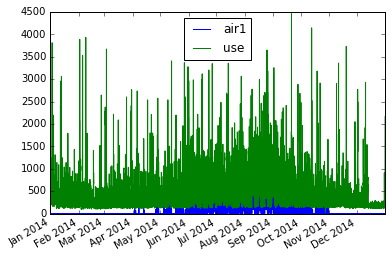

In [77]:
st['/94']['2014'][['air1', 'use']].plot()

516 has data collection issues! remove from all appliances.

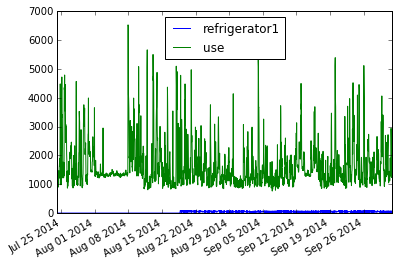

In [77]:
st['/4147']['7-1-2014':'10-1-2014'][['refrigerator1', 'use']].plot()

In [ ]:
4147 has some missing data. remove from fridge

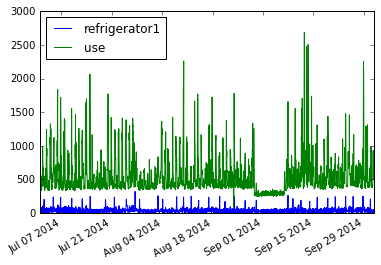

In [78]:
st['/4703']['7-1-2014':'10-1-2014'][['refrigerator1', 'use']].plot()

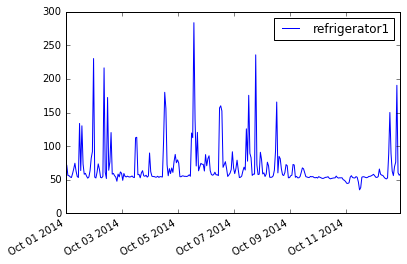

In [102]:
st['/2144']['10-1-2014':'11-1-2014'][['refrigerator1']].plot()

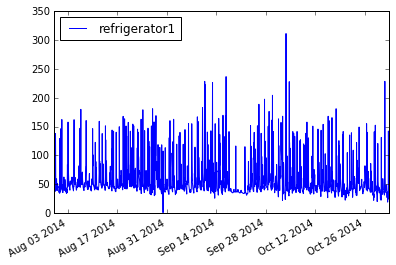

In [107]:
st['/7818']['7-1-2014':'11-1-2014'][['refrigerator1']].plot()

In [ ]:
2144 ends early. Put np.NaN in fridge, 2144, 10
7818 starts late, Put np.NaN in fridge, 7818, 7

In [139]:
acc_2 = {}
#for appliance in ["hvac","fridge","dw","mw"]:
for appliance in ["hvac"]:
    if appliance in acc_2:
        continue
    else:
        print appliance
        acc_2[appliance] = {}
        feature="Monthly+Static"
        for home in all_homes[appliance][:]:
            try:
                pred, gt, out_df = _find_accuracy(home, appliance, feature)
                acc_2[appliance][home]=out_df
                print home, acc_2[appliance][home].mean()
            except Exception, e:
                print e

hvac
232 85.5318120427
698 0.0
1879 69.7006293564
2144 57.8747660792
2523 0.0
2903 71.5896189227
3734 98.5087953823
Found array with 0 sample(s) (shape=(0, 3)) while a minimum of 1 is required.
4920 34.7913881549
4974 77.5048849213
5652 27.7081317313
5904 53.8384384148
7001 56.6933868386
8273 99.1291562447
8368 96.7165774147
8395 38.4708448082
9156 60.7288410349
9341 39.5936536109
9818 97.4500525303


In [143]:
pd.DataFrame(acc_2).mean()

hvac    59.212832
dtype: float64

In [144]:
df

,aggregate_7,aggregate_8,aggregate_9,aggregate_10,hvac_7,hvac_8,hvac_9,hvac_10,fridge_7,fridge_8,fridge_9,fridge_10,area
232,0.484139,0.495422,0.371931,694.200195,338.407410,334.595459,63.463852,15.140766,NaN,NaN,NaN,NaN,0.262653
547,0.550198,0.507525,0.608891,1517.996460,34.373417,18.198683,8.908184,0.437633,NaN,NaN,NaN,NaN,0.392850
698,0.529120,0.438695,0.411129,851.687927,168.810211,61.519470,2.300000,0.118233,64.191200,57.133865,54.823750,50.255817,0.289370
1350,0.180680,0.230210,0.124130,408.752808,16.532484,65.803162,0.599133,3.867483,66.516800,77.818665,59.687233,57.797764,0.282220
1766,0.225406,0.230578,0.201784,452.142517,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.325870
1879,0.504281,0.443358,0.301665,754.656860,294.709778,174.642090,0.552867,0.146300,85.370651,84.205200,73.029518,73.792221,0.619191
2144,0.579852,0.525803,0.410075,175.338425,598.515564,490.403564,303.959320,0.002017,59.276733,56.902199,55.143650,19.762566,0.133020
2523,0.754973,0.595664,0.519899,1000.518616,135.648438,70.280182,15.237200,8.047383,78.406364,75.180016,69.187485,63.164581,0.653622
2903,0.345137,0.277248,0.264845,503.319336,120.667900,73.585297,54.004265,15.935367,78.262619,72.784721,63.093933,67.747849,0.417121
3104,0.110492,0.109131,0.116767,248.196533,11.799868,1.095700,0.020450,0.008650,54.740536,53.272900,48.935200,45.424648,0.133020


In [150]:
import matplotlib.pyplot as plt

In [155]:
import sys
sys.path.append("../code/")

In [156]:
from common_functions import tableau20blind, format_axes

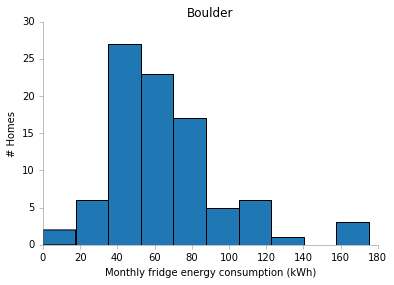

In [163]:
pd.Series(df[['fridge_7','fridge_8','fridge_9']].dropna().values.flatten()).hist(color=tableau20blind[0])
plt.grid(False)
format_axes(plt.gca())
plt.xlabel("Monthly fridge energy consumption (kWh)")
plt.title("Boulder")
plt.ylabel("# Homes")
plt.savefig("../results/boulder_fridge_hist.png")

In [64]:
%matplotlib inline

In [67]:
df[['hvac_7','hvac_8','hvac_9']].dropna().median()

hvac_7    487.873474
hvac_8    599.115112
hvac_9    343.514694
dtype: float64